In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import  Point

/Users/ryangeygan/.pyenv/versions/venv.regen-carbon-pipeline/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [35]:
## GLOBAL vars
HARVEST_DATA_PATH = '/Users/ryangeygan/garbage/FBN/reinterviewdataproblem/harvest_sample_data.csv'
PLANTING_DATA_PATH = '/Users/ryangeygan/garbage/FBN/reinterviewdataproblem/planting_sample_data.csv'

HARVEST_DATA = pd.read_csv(HARVEST_DATA_PATH)

In [12]:
def visualize_data(harvest_data_path, planting_data_path):
    """
    To visualize the GPS data - how planting vs. harvest data are oriented
    """

    #Load data as pandas dataframes
    harvest_data = pd.read_csv(harvest_data_path)
    planting_data = pd.read_csv(planting_data_path)
    #Create GeoDataFrames from pd.DataFrames and set crs
    #Could also load csv's directly as GeoDataFrames
    harvest_gdf = gpd.GeoDataFrame(harvest_data,
                                      geometry=gpd.points_from_xy(harvest_data.long, harvest_data.lat))
    harvest_gdf.crs = 'epsg:4326'

    planting_gdf = gpd.GeoDataFrame(planting_data,
                                       geometry=gpd.points_from_xy(planting_data.long, planting_data.lat))
    planting_gdf.crs = 'epsg:4326'

    ax = planting_gdf.plot(marker='1', markersize=30, color='green',label='planting')
    harvest_gdf.plot(ax=ax, markersize=3, color='blue',label='harvest')

    ax.legend()
    plt.title(label='Planting and Harvest GPS Points')

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    plt.rcParams['figure.figsize'] = [75, 30]

    return

In [33]:
def visualize_variety(planting_data_path):
    """
    To visualize how the cultivars are oriented in the field
    """

    #Load data as pandas dataframes
    planting_data = pd.read_csv(planting_data_path)
    #Create GeoDataFrames from pd.DataFrames and set crs
    #Could also load csv's directly as GeoDataFrames

    planting_gdf = gpd.GeoDataFrame(planting_data,
                                       geometry=gpd.points_from_xy(planting_data.long, planting_data.lat))
    planting_gdf.crs = 'epsg:4326'

    ax = planting_gdf.plot(column='variety',legend=True)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    plt.rcParams['figure.figsize'] = [75, 30]

    return

In [39]:
def ckdnearest(harvest_data_path, planting_data_path):
    """
    This is the method that links harvest and planting data
    """
    
    #In a larger pipeline, there would be methods that load csv's and create geodataframes as stand alone functions
    #Load data as pandas dataframes
    harvest_data = pd.read_csv(harvest_data_path)
    planting_data = pd.read_csv(planting_data_path)
    #Create GeoDataFrames from pd.DataFrames and set crs
    #Could also load csv's directly as GeoDataFrames
    harvest_gdf = gpd.GeoDataFrame(harvest_data,
                                      geometry=gpd.points_from_xy(harvest_data.long, harvest_data.lat))
    harvest_gdf.crs = 'epsg:4326'

    planting_gdf = gpd.GeoDataFrame(planting_data,
                                       geometry=gpd.points_from_xy(planting_data.long, planting_data.lat))
    planting_gdf.crs = 'epsg:4326'

    #Create list of tuples from numpy arrays of geometries
    nA = np.array(list(harvest_gdf.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(planting_gdf.geometry.apply(lambda x: (x.x, x.y))))

    #Set cKDTree params/query
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)

    #Locate nearest point by index
    gdB_nearest = planting_gdf.iloc[idx].drop(columns="geometry").reset_index(drop=True)

    #Concatenate dataframes
    gdf = pd.concat(
        [
            harvest_gdf.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ],
        axis=1)

    gdf_data = gdf[['geometry','variety', 'seeding_rate', 'seed_spacing', 'speed','yield']]
    gdf_dist = gdf[['geometry','dist']]

    data = pd.DataFrame(gdf[['variety', 'seeding_rate', 'seed_spacing', 'speed','yield']])

    return gdf_data, gdf_dist, data

In [44]:
def visualize_vars(data: gpd.GeoDataFrame):
    """
    To visualize the spatial variation of each variable
    """


    ncols = 2
    nrows = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    counter = 2
    for i in range(nrows):
        for j in range(ncols):

            ax = axes[i][j]

            # Plot when we have data
            if counter < len(data.columns):

                data.plot(column = data[data.columns[counter]], cmap='OrRd', scheme='quantiles',ax=ax,label='{}'.format(data.columns[counter]))

                ax.axes.get_xaxis().set_visible(False)
                ax.axes.get_yaxis().set_visible(False)

                ax.set_title(f'{data.columns[counter]}')

            # Remove axis when we no longer have data
            else:
                ax.set_axis_off()

            counter += 1

    return

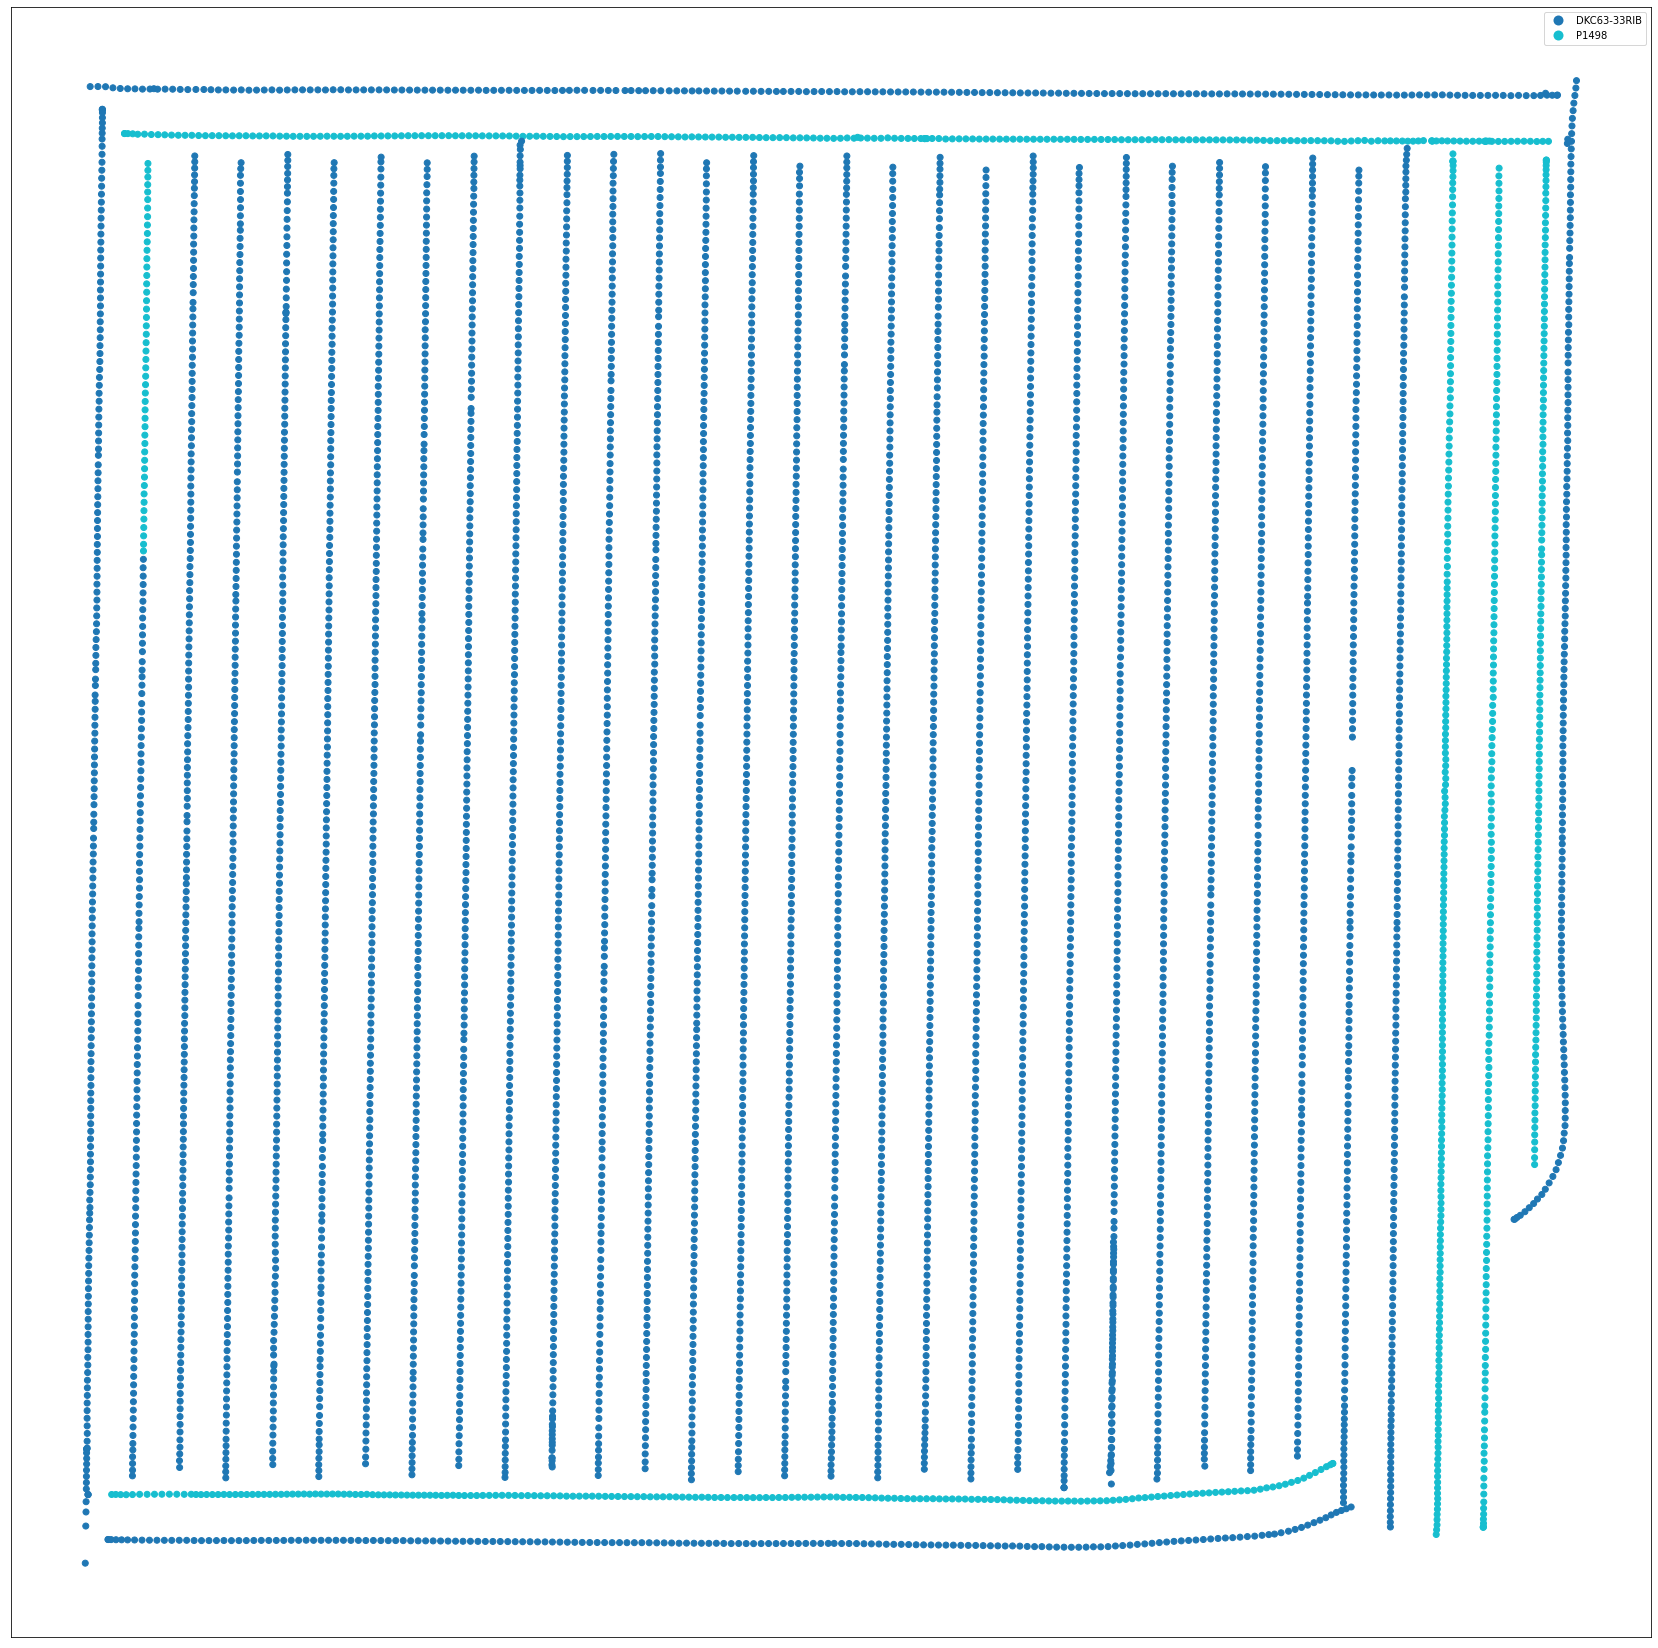

In [34]:
visualize_variety(PLANTING_DATA_PATH)

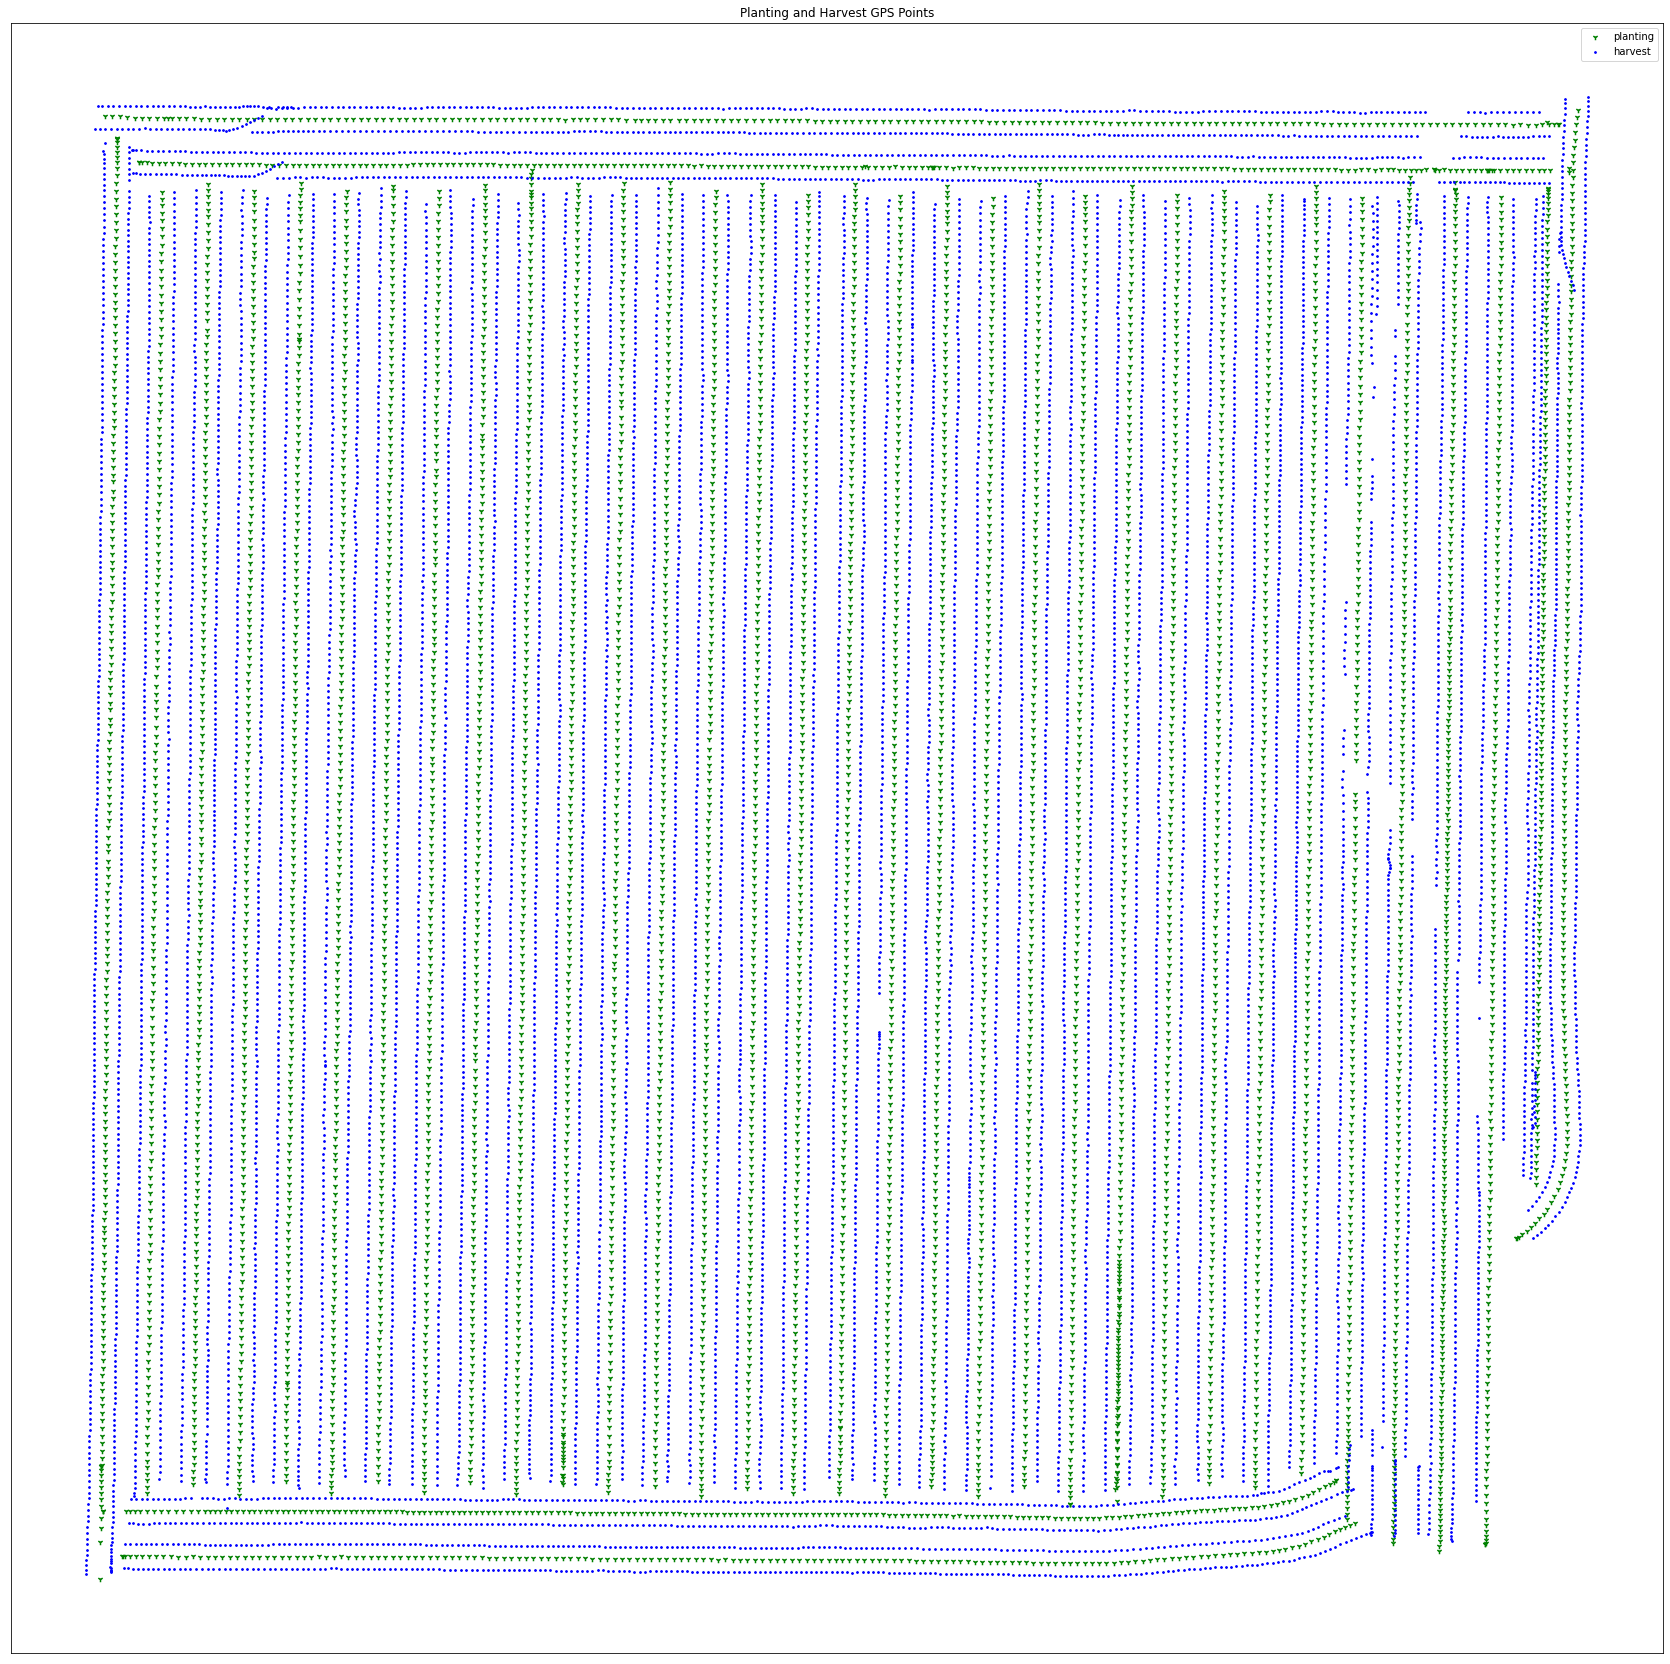

In [26]:
visualize_data(HARVEST_DATA_PATH, PLANTING_DATA_PATH)

In [40]:
gdf, distances, combined_data  = ckdnearest(HARVEST_DATA_PATH, PLANTING_DATA_PATH)

In [41]:
combined_data.head()

,variety,seeding_rate,seed_spacing,speed,yield
0,DKC63-33RIB,37.0791,5.639,3.56,88.451156
1,DKC63-33RIB,37.0791,5.639,3.56,102.173517
2,DKC63-33RIB,37.0791,5.639,3.56,191.420756
3,DKC63-33RIB,37.0791,5.639,3.58,236.556217
4,DKC63-33RIB,37.0791,5.639,3.74,224.822367


In [42]:
len(combined_data) == len(HARVEST_DATA)

True

In [43]:
distances.head()

,geometry,dist
0,POINT (-91.84999 40.37610),0.000043
1,POINT (-91.84999 40.37611),0.000040
2,POINT (-91.84999 40.37612),0.000039
3,POINT (-91.84999 40.37613),0.000039
4,POINT (-91.84999 40.37614),0.000039


Text(0, 0.5, 'Frequency')

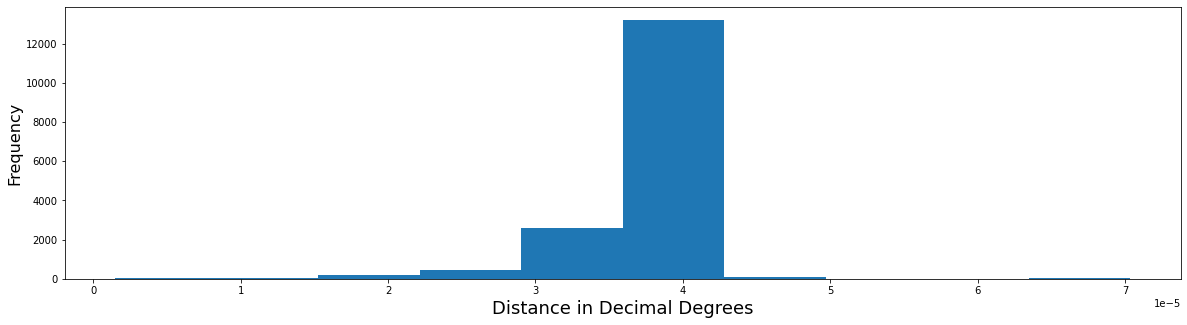

In [23]:
(n, bins, patches) = plt.hist(distances.dist, bins=10, label='hst')
plt.xlabel('Distance in Decimal Degrees', fontsize=18)
plt.ylabel('Frequency', fontsize=16)

The following plots help to visualize the spatial variation of the variables in the data. Seeding rate and inversely seed spacing were variable in different sections of the field. There is a section of the field were yield appeared to be consistently lower. But the purpose of these visualizations in concert with the visuals above, is to give a high level view of whether any of these variables are varying spatially in similar ways. It appears they are not. Further spatial statistics could reveal this in more detail but in general there does not seem to be any strong spatial relationship between where the different cultivars are planted, the planting parameters, or yield. There may be something of an edge effect visually present in the yield data and there does seem to be a concentration of lower yeilds toward the right side of the field, but that doesn't overlap strongly with other patterns.

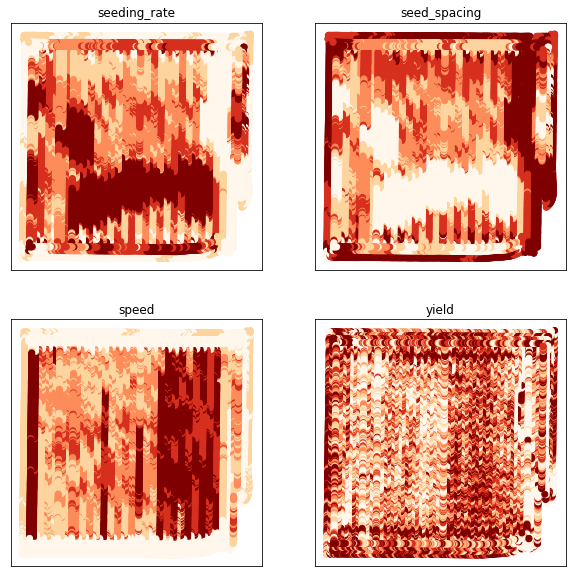

In [45]:
visualize_vars(gdf)